KAGGLE + COLAB SET UP

1. Uploading kaggle.json  & moving file to correct location

In [ ]:
# Delete the existing (non-git) folder
!rm -rf /content/deep-xray-diagnosis-machkevds

# Clone the GitHub repo cleanly
!git clone https://github.com/machkevds/deep-xray-diagnosis-machkevds.git

# Move into the repo
%cd /content/deep-xray-diagnosis-machkevds


Cloning into 'deep-xray-diagnosis-machkevds'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 1), reused 6 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), 786.23 KiB | 5.78 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/deep-xray-diagnosis-machkevds


In [ ]:
import os
os.getcwd()


'/content/deep-xray-diagnosis-machkevds'

In [ ]:
!git config --global user.name "machkevds"
!git config --global user.email "kevindslzr@gmail.com"


In [ ]:
#UPDATE
# Inside your repo folder after OPENING THE GITHUB NOTEBOOK WITHIN COLAB!!!

YOUR_TOKEN = ""

!git add xray-diag-machkds.ipynb
!git commit -m "Update: GIT SETUP"

# Push using the token variable — this is the key change:
!git push https://{YOUR_TOKEN}@github.com/machkevds/deep-xray-diagnosis-machkevds.git main


On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Everything up-to-date


In [1]:
from google.colab import files
files.upload() # upload kaggle json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"machkevds","key":"678fe96424c7399770a2ab98c064ba38"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip -d ./data

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:14<00:00, 244MB/s]
100% 2.29G/2.29G [00:14<00:00, 174MB/s]


2. Exploring dataset structure &visualizing sample images

In [4]:
import os

#root folder of dataset
data_dir = "./data/chest_xray"

#loop over train val and test directories
#for each split go into its folder & subfolders "3 labels"
for split in ["train", "val", "test"]:
  split_path = os.path.join(data_dir, split)
  print(f"\n{split.upper()} SET:")

#for each label, count number of images it contains
  for label in os.listdir(split_path):
    label_path = os.path.join(split_path, label)
    count = len(os.listdir(label_path))
    print(f" - {label}: {count} images")


TRAIN SET:
 - PNEUMONIA: 3875 images
 - NORMAL: 1341 images

VAL SET:
 - PNEUMONIA: 8 images
 - NORMAL: 8 images

TEST SET:
 - PNEUMONIA: 390 images
 - NORMAL: 234 images


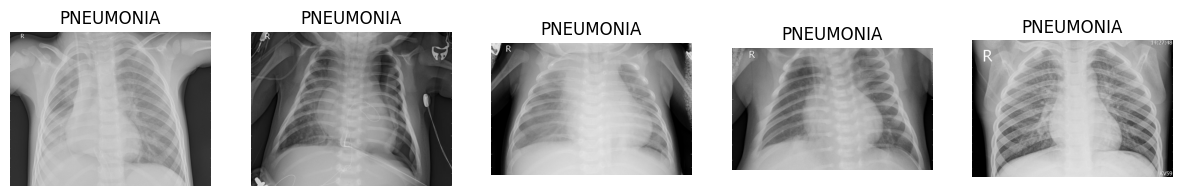

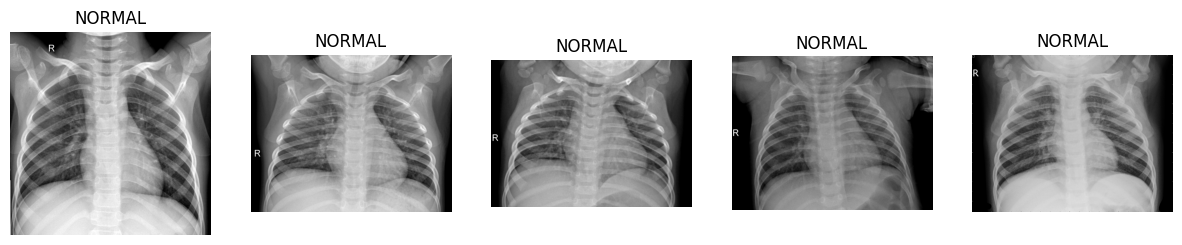

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def show_random_images(split="train", label="PNEUMONIA", num=5):
  path = os.path.join(data_dir, split, label)
  files = random.sample(os.listdir(path), num)

  plt.figure(figsize=(15,3))
  for i, f in enumerate(files):
    img = mpimg.imread(os.path.join(path, f))
    plt.subplot(1, num, i+1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(label)
  plt.show()

show_random_images("train", "PNEUMONIA")
show_random_images("train", "NORMAL")

3. Data Preprocessing (Keras)

In [6]:
#importing libraries and defining paths

import tensorflow as tf
from tensorflow.keras import layers
import os

#set base paths
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

#set standard image size for CNNs
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

In [7]:
# load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False  # for consistent test evaluation, confusion matrix?
)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 16 files belonging to 2 classes.
Using 3 files for validation.
Found 624 files belonging to 2 classes.


In [8]:
# DATA AUGMENTATION added on KEVPOCH 3
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

4. Building a CNN from scratch in Keras (TensorFlow)

In [9]:
# building the CNN KEVPOCH 1

# commented out on KEVPOCH 5

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# model = Sequential([
#     # first convolution + pooling
#     Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
#     MaxPooling2D(pool_size=(2,2)),

#     # second convolution + pooling
#     Conv2D(64,(3,3), activation='relu'),
#     MaxPooling2D(pool_size=(2,2)),

#     #third convolution + pooling
#     Conv2D(128, (3,3), activation='relu'),
#     MaxPooling2D(pool_size=(2,2)),

#     # flatten & fully connect layers
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5), #helps with overfitting
#     Dense(1, activation='sigmoid') #binary classification w sigmoid
# ])

# model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# compile the model

#commented 0ut on KEvpoch 5

# model.compile(
#     loss='binary_crossentropy',
#     optimizer='adam',
#     metrics=['accuracy']
# )

In [9]:
# adding CALLBACKS added on KEVPOCH 3

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss',
                  patience=4, #patience from 3 to 4 on kevpoch 6
                  restore_best_weights=True,
                  verbose=1 # added on kevpoch 6, recommended to 1, it will print early stopping log
                  ),
    ReduceLROnPlateau(monitor='val_loss',
                      factor=0.2, #from 0.1 to 0.2 on kevpoch 6, more aggresive drop in lr
                      patience=2,
                      min_lr=1e-6, # added on kevpoch6
                      verbose=1 #added on kevpoch6
                      )
]

In [18]:
# adding CLASS WEIGHTING added on KEVPOCH 4
# commented out on KEVPOCH 5 - ctrl + /
# custom CLASS WEIGHTING KEVPOCH 7

from sklearn.utils import class_weight
import numpy as np

# 0 = Normal, 1 = Pneumonia
class_labels= [0] * 1341 + [1] * 3875
class_weights = {
    0: 1.5, # normal class gets more weight # custom class weight KEVPOCH
    1: 1.0 # pneu class stays the same
}

class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)
print("Using custom class weights: Normal=2.0, Pneumonia=1.0")

Class weights: {0: 0, 1: 1}
Using custom class weights: Normal=2.0, Pneumonia=1.0


In [19]:
# TRANSFER LEARNING added on KEVPOCH 5
# loading and preparing MobileNetV2

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# loading base model (pre trained on ImageNet)
base_model = MobileNetV2(input_shape=(150,150,3), include_top=False, weights='imagenet')
base_model.trainable = True # freeze all layers initially, unfreezed on kevpoch 6

for layer in base_model.layers[:-20]:# unfreezing the last 20 layers
    layer.trainable = False

# Adding a custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Defining the model
model = Model(inputs=base_model.input, outputs=output)

# Compiling the model
model.compile(
    optimizer=Adam(learning_rate=1e-5), #lr = 1e-4 kevpoch 5, lr = 1e-5 kevpoch 6
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


<ipython-input-19-bef010851318>:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(150,150,3), include_top=False, weights='imagenet')


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 75, 75,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 75, 75,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 75, 75,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 75, 75,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 75, 75,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 75, 75,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 77, 77,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 38, 38,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 38, 38,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 1,370,177 (5.23 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

In [20]:
# train the model

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 10,
    callbacks=callbacks, # added on KEVPOCH 3, using EarlyStopping / ReduceLROnPlateau
    class_weight={0: 1.5, 1: 1.0} # added on KEVPOCH 4, commented out KEVPOCH 5, csutom one added KEVPOCH 7
)

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 57s 332ms/step - accuracy: 0.6297 - loss: 0.7539 - val_accuracy: 0.6667 - val_loss: 0.4484 - learning_rate: 1.0000e-05
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 270ms/step - accuracy: 0.8267 - loss: 0.4662 - val_accuracy: 1.0000 - val_loss: 0.3711 - learning_rate: 1.0000e-05
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 42s 278ms/step - accuracy: 0.8648 - loss: 0.3692 - val_accuracy: 1.0000 - val_loss: 0.3392 - learning_rate: 1.0000e-05
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 277ms/step - accuracy: 0.8888 - loss: 0.3337 - val_accuracy: 1.0000 - val_loss: 0.3146 - learning_rate: 1.0000e-05
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 277ms/step - accuracy: 0.8998 - loss: 0.2995 - val_accuracy: 1.0000 - val_loss: 0.3283 - learning_rate: 1.0000e-05
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.9034 - loss: 0.2855
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 277ms/s

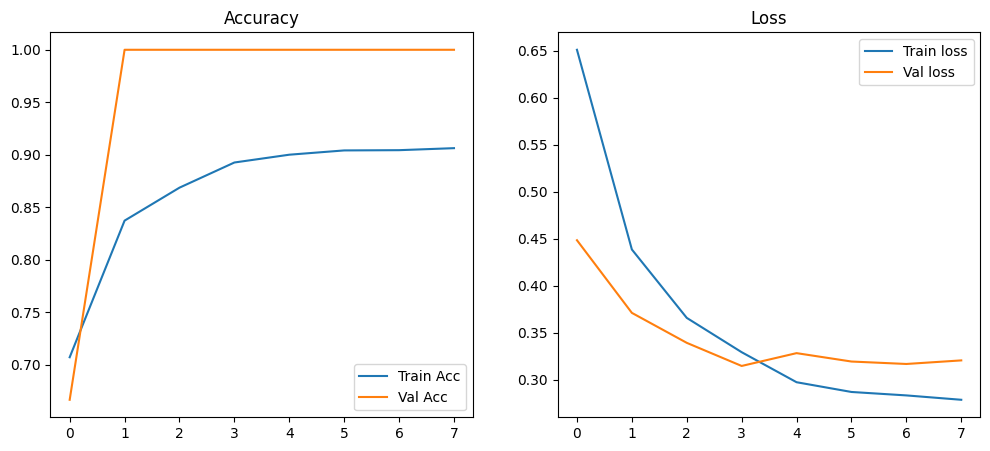

In [21]:
# plot training and validation performance

import matplotlib.pyplot as plt

def plot_training(history):
  acc= history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(12, 5))

  plt.subplot(1,2,1)
  plt.plot(acc, label="Train Acc")
  plt.plot(val_acc, label="Val Acc")
  plt.title('Accuracy')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(loss, label='Train loss')
  plt.plot(val_loss, label="Val loss")
  plt.title('Loss')
  plt.legend()

  plt.show()

plot_training(history)

In [22]:
# function that evaluates trained model on a test_ds, displays metrics
# ADDED ON KEVPOCH 4

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, test_ds, class_names):

  y_true =[]
  y_pred = []

  for images, labels in test_ds:
    preds = model.predict(images) # model predictions (probabilities)
    preds = tf.squeeze(tf.round(preds)) # binary prediction threshhold
    y_pred.extend(preds.numpy()) # store predicted class
    y_true.extend(labels.numpy()) # store true class

  #convert to nparray
  y_true = np.array(y_true, dtype=int)
  y_pred = np.array(y_pred, dtype=int)

  #metrics
  # building the confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  #classification report
  cr = classification_report(y_true, y_pred, target_names=class_names)

  #plotting

  plt.figure(figsize=(6,5))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix')
  plt.show()

  # text report
  print("Classification Report:\n")
  print(cr)

In [ ]:
# Saving model ONLY SAVE WHEN MODEL IS READY FOR DEPLOYEMENT
model.save("mobilenetv2_pneumonia.h5")

"""
Model Details:

- Accuracy: 81%
- Normal recall: 0.56
- Pneumonia recall: 0.96
- Notes: Good at detecting Pneumonia, poor on Normal

'''
"""

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


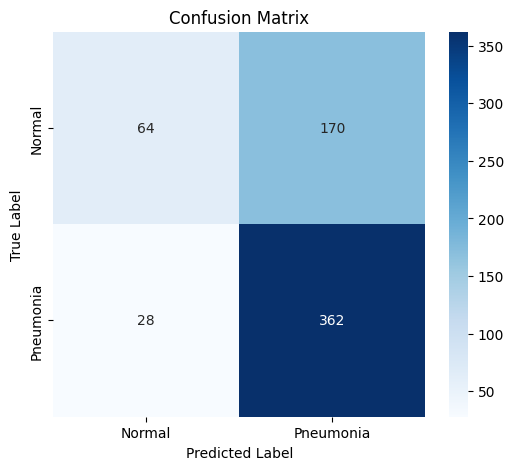

Classification Report:

              precision    recall  f1-score   support

      Normal       0.70      0.27      0.39       234
   Pneumonia       0.68      0.93      0.79       390

    accuracy                           0.68       624
   macro avg       0.69      0.60      0.59       624
weighted avg       0.69      0.68      0.64       624



In [23]:
# utilizing the created evaluate_model func
# load & evaluate saved models

from tensorflow.keras.models import load_model

# load model if saved and in directory, if trained here manually you can evaluate without loading
#model = load_model("cnn_unweighted_v1.h5")

evaluate_model(model, test_ds, class_names=['Normal', 'Pneumonia'])


In [ ]:
# NOTES:

#KEVPOCH 1 (personal term to track my changes to the models)
# overfitting:
#so I increased dropout to 0.6, added validation_split, increased rotation_range from 15 to 30, epochs from 10 to 15
# I noticed that ImageDataGenerator is DEPRECATED, so I will definetely move to a modern approach, will use image_dataset_from_directory
# this attempt failed and caused ever worse overfitting, so now I will revert changes to original and commit on github for tracking.
# you also forgot to add the validation loss curve on the loss graph, it will now be added


#KEVPOCH 2 TEST 2 IS IT COMMITED?
# RESULTS
# commiting was succesful, OPEN GITHUB NOTEBOOK from the colab dashborad, and finalyl you need to save with Ctrl+S and then it will open a commit tab
# migrated to modern approach, trained again, train acc 98% validation starts at 93% then drops to 75%, then spikes back up and down
# loss graph has some overfitting, test loss is 3.o9 meaning the loss from the model tested on raw non augmented test data
# model is overfitting []
#KEVPOCH 3
# BEFORE RUNNING
# few questions asked to identify any possible flaws:
# How many samples are there in each split? 3875 for PNEUMONIA and NORMAL 1341, sufficient but NOT BALAnced ~3:1 in favor of pneumonia
# Dropout being used? Yes
# Using data augmentation? No, could be a key reason for overfitting | train acc = 98%, test acc = 74%, test loss = high 3.9...
# Are images similar? Yeah, they obviously are, thats why its hard to generalize when its at risk of memorization,

# CHANGES
# Will add data augmentation and callbacks
# Summary of changes before results
#There is a larger model now, and has a more meaningful validation split, data augmentation added for improved generalization
# Callbacks applied, EarlyStopping and ReduceLROnPlateau


# RESULTS
# Now
# Train acc = 0.8872, Val acc = 1.00 or 100%, Test loss = 0.612
# Before
# Train acc = 0.98.. ,Val acc =(~75% - 93%) erratic, Test loss = ~3.99

# Graph
# Training loss decreases smoothly, val acc stabilizes early,
#val loss flattens (no overfitting yet), LR drops at epoch 6 (ReduceLROnPlateau), helping sabilize val loss

# IMPROVEMENTS
# data aug prevented overfitting
# larger val split, allowed model get meaningful feedback on training
# callbacks stopped early before overfitting, reduced lr when needed
# shuffling and prefetch improved stability & speed

# OBSERVATIONS
# VAL ACC hit 100%, val split voerlaps with images too similar to training set, val set is still maller or easier than test set
# model overfits to validation in fewer steps, this is ok, apparetnly test acc us still the true metric of generalization
# test acc was raised from 73% to 80% which is what matters


In [ ]:
#KEVPOCH 4
# BEFORE RUNNNING
# running a confusion matrix + precision/recall
# after confusion matrix, moving to transfer learning
#consider deployment only when model is stable/ performs well/ verfied with real world like test cases

# CHANGES
# added a function that will take care of the model evaluation after training

# OBSERVATIONS
# NORMAL | True Neg = 132 | False Pos = 102 (Falso alarm)
# PNEUMONIA | False Neg = 16 | True Pos = 374 (very few false negatives)

# very high recall for pneumonia 96%
#model ALMOST never misses actual pneumonia, critical in medical where false negatives are dangerous

# low recall for Normal
#model often mistakes healthy Xrays as pneumonia 56%
# 102 false positives ~43% of all normal cases (102 out of 234) alarming if deployed

#Class  Precision	 Recall	F1-Score	Support
#Normal	   0.89	  0.56	    0.69	     234
#Pneumonia 0.79	  0.96	    0.86	     390

# model may be too agressive, often wrongly flags normal images as pneumonia

In [ ]:
#KEVPOCH 5
# Before Running
# possible fixes, class weighting during training, threshold tuning, transfer learning

# Changes
# Will add Class Weighting (did not work)
# Will add transfer learning, MobileNetV2

# Observations
# model got worse than previous iteration. it will be removed
#todo remove/comment out class weighting, and try transfer learning

# TRANSFER LEARNING
# MobileNetV2 uses inverted residual blocks with expansion/contraction, expands channels before depthwise conv, compressed back with a 1x1 conv, saves parameters while preserving power
# 2.26 M Frozen weights from pretraining on ImageNet (CNN from scratch had 4.8M parameters)
# MobileNetV2 has 155+ layers
# It has 16 "blocks"
# Each block has multiple layers (conv, batch norm, ReLU, etc.).
# But most are frozen (already trained on ImageNet).
# Only the last few layers are trainable, the custom head created:
# GlobalAveragePooling2D
# Dense (128 neurons)
# Dense (1 neuron, output)
#Custom CNN had 9 layers

# val acc stuck at 100%, it flats, model may not be improving beyond a plateau, val set may be too easy
# model is not adapting to xray images, because it was loaded with freezed pretrained layers
# will have to train deeper layers to accomodate
# pretrained layers did not get updated, only the head
#in loss graph, val loss decreases early then rises, causing a bottle neck with train loss, possible early sign of overfitting
#in acc graph, the val acc flats at 1.00, there may be a plateau or val set is too easy

# CONCLUSION
# mobileNetv2 is more stable than previous model with scratch cnn
# full potential has not been used uet


In [ ]:
#KEVPOCH 6
# BEFORE RUNNING (changes done)
# Unfreeze last few layers of MobileNetV2
# lr 1e-4 to 1e-5
# Callbacks-> ReduceLROnPleteau -> factor 0.1 to 0.2 -> min_lr=1e-6, verbose=1
# Callbacks-> EarlyStopping -> patience 3 to 4 -> verbose=1

# RESULTS AFTER RUNNING
# ACC GRAPH Showing classic signs of overfitting
# LOSS GRAPH Overfitting with val loss degradation -> worsens with divergence, not just failing to generalize, DESTROYING PREV LEARNING
# CONF MATRIX
#Normal Precision 81%, 19% false positives, but terrible at recognizing healthy recall 15%
#Pneu Precision 66%, 34% are false alarms, recall 98%, misses 2% of sick people



# WHAT HAPPENED after FINE TUNING

# THE GOOD
# Model learned better features for pneumonia, FN 87 to 8, critical win for patient safety
# Train Acc up to 92% (but seems near perfect, suspicious)
# Pneu Recall 78% to 98%

# THE BAD
# Normal Class: Recall dropped 56% to 15%, FP increased 102 to 199
# Model flags almost everything as Pneu, losing generalization

In [ ]:
# KEVPOCH 7
# BEFORE RUNNING
# custom class weighting adjustment to take normal more seriously, Normal=2.0, Pneumonia=1.0

@@@ GITHUB SETUP @@@

In [ ]:
import os

# Replace with your info
os.environ['USER'] = 'machkevds'
os.environ['REPO'] = 'deep-xray-diagnosis-machkevds'

# Clone repo
%cd /content
!rm -rf {os.environ['REPO']}  # Remove old clone if needed
!git clone https://github.com/{os.environ['USER']}/{os.environ['REPO']}.git

# Go into repo
%cd /content/{os.environ['REPO']}
!git config --global user.name "machkevds"
!git config --global user.email "kevindslzr@gmail.com"


/content
Cloning into 'deep-xray-diagnosis-machkevds'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.
/content/deep-xray-diagnosis-machkevds


In [ ]:
!ls /content/*.ipynb


/content/xray-diag-machkds.ipynb


In [ ]:
# Replace with your actual notebook name if different
notebook_name = "xray-diag-machkds.ipynb"

# Move notebook into repo folder
!mv /content/{notebook_name} /content/{os.environ['REPO']}


In [ ]:
# Inside repo
%cd /content/{os.environ['REPO']}
!git add {notebook_name}
!git commit -m "Add notebook with initial CNN model 2:20pm"


/content/deep-xray-diagnosis-machkevds
[main 067cade] Add notebook with initial CNN model 2:20pm
 1 file changed, 1 insertion(+)
 create mode 100644 xray-diag-machkds.ipynb


In [ ]:
# Replace with new GitHub token (classic, repo scope)
GITHUB_TOKEN = ""

!git push https://{GITHUB_TOKEN}@github.com/{os.environ['USER']}/{os.environ['REPO']}.git main


remote: Repository not found.
fatal: repository 'https://github.com/{os.environ[USER]}/{os.environ[REPO]}.git/' not found
